In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 60)
pd.set_option('mode.chained_assignment',  None)

plt.rc('font',family='malgun gothic')

# 스마트카드 데이터
SMART_CARD = pd.read_csv('./data/SMART_CARD.csv', header = None)

# 공공데이터포털
getrouteinfoall = pd.read_csv('./data/getRouteInfoAll.csv', encoding = 'cp949', index_col = 0) # 전체 노선 기본정보 조회
getstationbyrouteall = pd.read_csv('./data/getStationByRouteAll.csv', encoding = 'cp949', index_col = 0) # 전체노선별경유정류소 정보 조회

# 정류장 데이터
bus_sttn = pd.read_csv('./data/bus_sttn.csv')

In [2]:
def smart_card_data_preprocessing(exdata):
    exdata.columns = ['SERIAL_NO', 'CARD_NO', 'GETON_YMD', 'GETON_TM', 'BUS_ROUTE_ID', 'BUS_CO_ID', 'BUS_CAR_ID', 'GETON_BUS_STTN_ID', 'GETOFF_BUS_STTN_ID',
                        'DRVR_ID', 'TRANSACTION_ID', 'TR_MEANS_TYPE', 'USR_TYPE', 'DRVN_START_YMD', 'DRVN_START_TM', 'GETOFF_YMD', 'GETOFF_TM', 'GETON_CALC_YMD',
                        'GETOFF_CALC_YMD', 'GETON_PAY', 'GETOFF_PAY', 'TRANSF_CNT', 'USR_CNT']
    exdata.drop(labels = ['SERIAL_NO', 'DRVR_ID','TRANSACTION_ID','USR_TYPE','DRVN_START_YMD','BUS_CO_ID','DRVN_START_TM','GETOFF_YMD','GETOFF_TM','GETON_CALC_YMD','GETOFF_CALC_YMD', 'GETON_PAY','GETOFF_PAY','TRANSF_CNT','GETOFF_BUS_STTN_ID'], axis = 1, inplace = True)


    exdata['GETON_TM'] = exdata['GETON_TM'].apply(lambda x: str(x).zfill(6)) # GETON_TM 컬럼 날짜형식으로 변환하기 위해 자릿수 맞춰주기

    # datetime 형식으로 변환 및 새로운 column 생성
    exdata['GETON_DATETIME'] = pd.to_datetime(exdata['GETON_YMD'].astype(str) + exdata['GETON_TM'].astype(str), format = '%Y%m%d%H%M%S')

    exdata['DAY'] = exdata['GETON_DATETIME'].dt.day
    exdata['WEEKDAY'] = exdata['GETON_DATETIME'].dt.weekday  

    # 급행/지선/간선만 필터링
    exdata = exdata[exdata['TR_MEANS_TYPE'].isin([675,676])]

    # 도시 노선만 사용하기 위해
    values_to_remove = [30300147, 30300148, 30300141, 30300137, 30300149, 30300103]
    exdata = exdata[~exdata['BUS_ROUTE_ID'].isin(values_to_remove)]

    # 평일만 추출
    weekday_values = [0, 1, 2, 3, 4]
    exdata = exdata[exdata['WEEKDAY'].isin(weekday_values)]

    # 6/6일 제거 / 6/19일 제거[결측치]
    exdata = exdata[exdata['DAY'] != 6]
    exdata = exdata[exdata['DAY'] != 19]

    # # 비가 온 날 제거
    # exdata = exdata[~exdata['DAY'].isin([26,29])]

    # 사용한 행 제거
    exdata.drop(labels = ['GETON_YMD','GETON_TM','TR_MEANS_TYPE','USR_CNT','WEEKDAY'], axis = 1, inplace = True)
    
    return exdata

In [3]:
SMART_CARD_DATA = smart_card_data_preprocessing(SMART_CARD)
SMART_CARD_DATA.head(2)

,CARD_NO,BUS_ROUTE_ID,BUS_CAR_ID,GETON_BUS_STTN_ID,GETON_DATETIME,DAY
3,804099084,30300053,130752377,8005978,2023-06-01 05:20:33,1
35,929954937,30300043,130759616,8001243,2023-06-01 05:30:22,1


### 시각화

In [4]:
SMART_CARD_DATA['GETON_HOUR'] = SMART_CARD_DATA['GETON_DATETIME'].dt.hour

# 출/퇴근 시간대만 필터링
SMART_CARD_DATA_ = SMART_CARD_DATA[SMART_CARD_DATA['GETON_HOUR'].isin([7,8,16,17,18])]
SMART_CARD_DATA_

,CARD_NO,BUS_ROUTE_ID,BUS_CAR_ID,GETON_BUS_STTN_ID,GETON_DATETIME,DAY,GETON_HOUR
16361,803929993,30300070,130752605,8002825,2023-06-01 07:00:00,1,7
16362,803166584,30300037,130759023,8005517,2023-06-01 07:00:00,1,7
16363,911563091,30300071,130759180,8002572,2023-06-01 07:00:00,1,7
16364,934924962,30300069,130759715,8003044,2023-06-01 07:00:00,1,7
16365,549151960,30300096,130752063,8002553,2023-06-01 07:00:00,1,7
...,...,...,...,...,...,...,...
10698195,745323770,30300077,130752010,8002434,2023-06-30 18:59:59,30,18
10698196,541380065,30300087,130759614,8002088,2023-06-30 18:59:59,30,18
10698198,918362716,30300054,130759382,8002452,2023-06-30 18:59:59,30,18
10698199,781295883,30300036,130759520,8002407,2023-06-30 18:59:59,30,18


In [5]:
getrouteinfoall_merge_df = getrouteinfoall[['ALLO_INTERVAL','ROUTE_CD','ROUTE_NO']]

In [47]:
allo_interval_merge = SMART_CARD_DATA_.merge(getrouteinfoall_merge_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
allo_interval_merge = allo_interval_merge[['ROUTE_NO','CARD_NO','ALLO_INTERVAL']]
bus_usage = allo_interval_merge.groupby("ROUTE_NO").size().reset_index(name="USAGE_COUNT")
bus_usage_merge = bus_usage.merge(getrouteinfoall_merge_df, left_on = 'ROUTE_NO', right_on = 'ROUTE_NO')
bus_usage_merge = bus_usage_merge[['ROUTE_NO','USAGE_COUNT','ALLO_INTERVAL']]
bus_usage_merge['ALLO_INTERVAL'] = bus_usage_merge['ALLO_INTERVAL'].astype(int)
bus_usage_merge['USAGE_COUNT'] = (bus_usage_merge['USAGE_COUNT']/18).astype(int)
bus_usage_merge_work = bus_usage_merge[bus_usage_merge['ROUTE_NO']!='2']

In [48]:
allo_interval_merge = SMART_CARD_DATA.merge(getrouteinfoall_merge_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
allo_interval_merge = allo_interval_merge[['ROUTE_NO','CARD_NO','ALLO_INTERVAL']]
bus_usage = allo_interval_merge.groupby("ROUTE_NO").size().reset_index(name="USAGE_COUNT")
bus_usage_merge = bus_usage.merge(getrouteinfoall_merge_df, left_on = 'ROUTE_NO', right_on = 'ROUTE_NO')
bus_usage_merge = bus_usage_merge[['ROUTE_NO','USAGE_COUNT','ALLO_INTERVAL']]
bus_usage_merge['ALLO_INTERVAL'] = bus_usage_merge['ALLO_INTERVAL'].astype(int)
bus_usage_merge['USAGE_COUNT'] = (bus_usage_merge['USAGE_COUNT']/18).astype(int)
bus_usage_merge_all = bus_usage_merge[bus_usage_merge['ROUTE_NO']!='2']

산점도 시각화

In [169]:
# import plotly.express as px

# # Plotly로 산점도 그래프 그리기
# fig = px.scatter(
#     bus_usage_merge,
#     x="USAGE_COUNT",
#     y="ALLO_INTERVAL",
#     color="ROUTE_NO",
#     color_continuous_scale="viridis",
#     labels={"USAGE_COUNT": "버스 이용량", "ALLO_INTERVAL": "배차간격 (분)"},
#     title="버스 노선별 이용량에 따른 배차간격",
#     trendline="ols"  # 선형 회귀선 추가
# )

# fig.update_coloraxes(colorbar_title="버스 노선번호")

# # Customize x-axis tick labels to display numbers without abbreviation
# fig.update_xaxes(tickformat="d")

# # Customize y-axis tick labels to display numbers without abbreviation
# fig.update_yaxes(tickformat="d")

# fig.show()


회귀선 시각화

In [170]:
# import seaborn as sns
# # seaborn을 사용하여 산점도 그래프와 선형 회귀선 그리기
# plt.figure(figsize=(50, 30))
# sns.scatterplot(data=bus_usage_merge, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")
# sns.regplot(data=bus_usage_merge, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, color='black', line_kws={"color": "red"})
# plt.xlabel("이용량")
# plt.ylabel("배차간격 (분)")
# plt.title("이용량에 따른 배차간격")

# # 데이터 포인트에 레이블 달기
# for route, usage, interval in zip(bus_usage_merge["ROUTE_NO"], bus_usage_merge["USAGE_COUNT"], bus_usage_merge["ALLO_INTERVAL"]):
#     plt.annotate(route,
#                  xy=(usage, interval),
#                  xytext=(-5, 0),
#                  textcoords='offset points',
#                  fontsize=10)  # 레이블 텍스트 크기 조정

# # 범례 제거
# plt.legend().remove()

# plt.show()

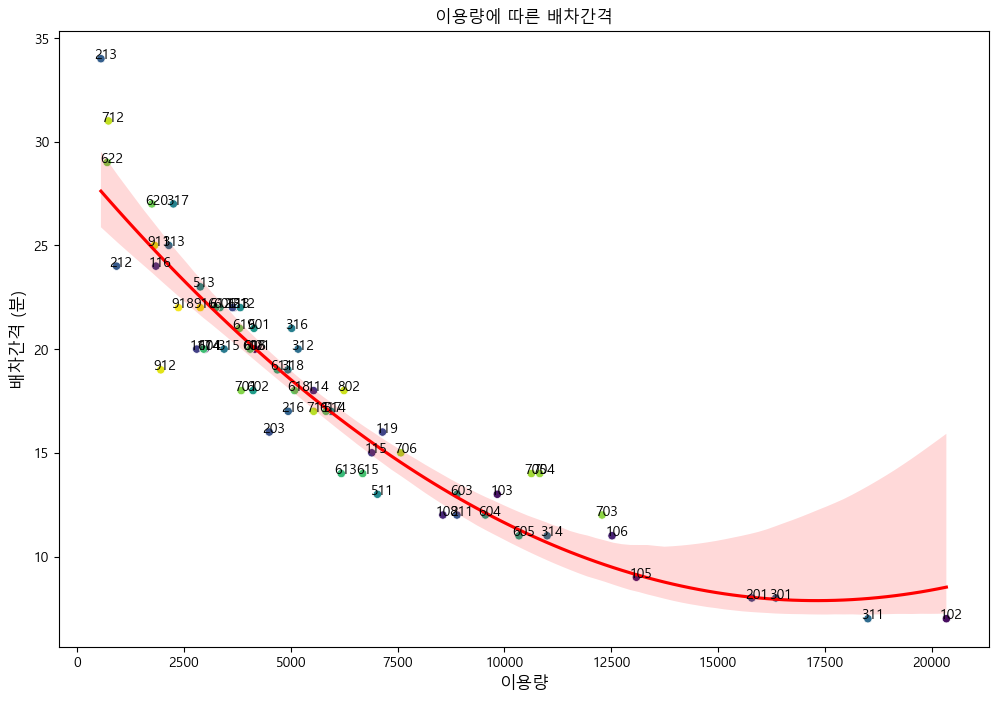

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 산점도 그래프 그리기
sns.scatterplot(data=bus_usage_merge_all, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")

# 2차 곡선 회귀선 그리기
sns.regplot(data=bus_usage_merge_all, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, order=2, color='black', line_kws={"color": "red"})

# 데이터 포인트에 레이블 달기
for route, usage, interval in zip(bus_usage_merge_all["ROUTE_NO"], bus_usage_merge_all["USAGE_COUNT"], bus_usage_merge_all["ALLO_INTERVAL"]):
    plt.annotate(route,
                 xy=(usage, interval),
                 xytext=(-5, 0),
                 textcoords='offset points',
                 fontsize=10)

# X, Y 축 레이블 및 타이틀 설정
plt.xlabel("이용량", fontsize = 12)
plt.ylabel("배차간격 (분)", fontsize = 12)
plt.title("이용량에 따른 배차간격", fontsize = 12)

# 범례 제거
plt.legend().remove()

plt.show()
# output_line1


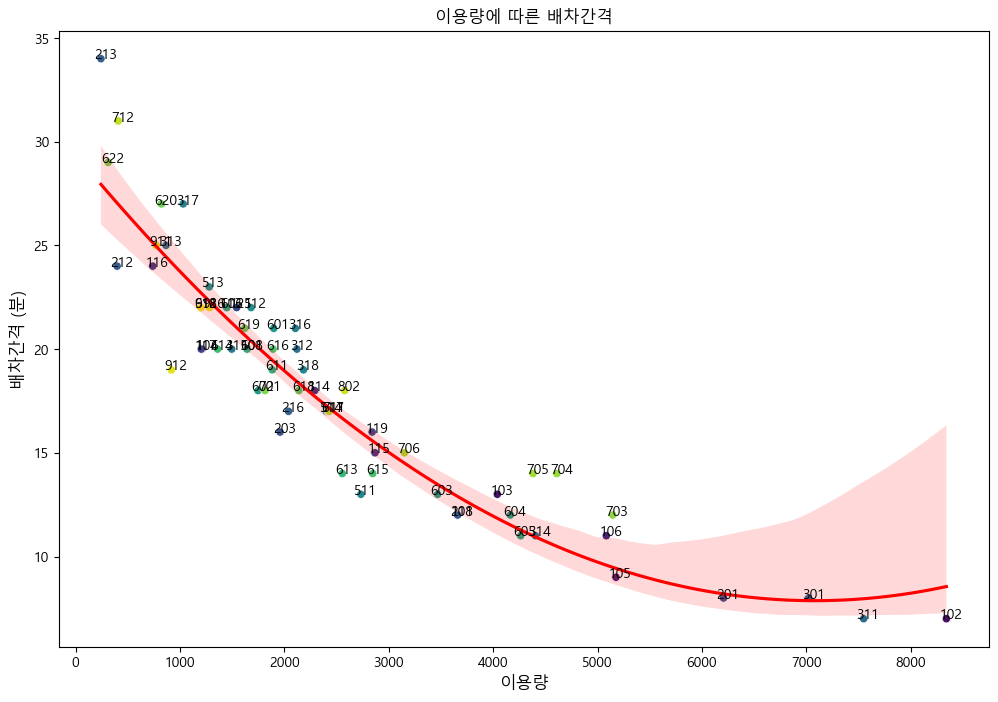

In [50]:
# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 산점도 그래프 그리기
sns.scatterplot(data=bus_usage_merge_work, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")

# 2차 곡선 회귀선 그리기
sns.regplot(data=bus_usage_merge_work, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, order=2, color='black', line_kws={"color": "red"})

# 데이터 포인트에 레이블 달기
for route, usage, interval in zip(bus_usage_merge_work["ROUTE_NO"], bus_usage_merge_work["USAGE_COUNT"], bus_usage_merge_work["ALLO_INTERVAL"]):
    plt.annotate(route,
                 xy=(usage, interval),
                 xytext=(-5, 0),
                 textcoords='offset points',
                 fontsize=10)

# X, Y 축 레이블 및 타이틀 설정
plt.xlabel("이용량", fontsize = 12)
plt.ylabel("배차간격 (분)", fontsize = 12)
plt.title("이용량에 따른 배차간격", fontsize = 12)

# 범례 제거
plt.legend().remove()

plt.show()
# output_line2

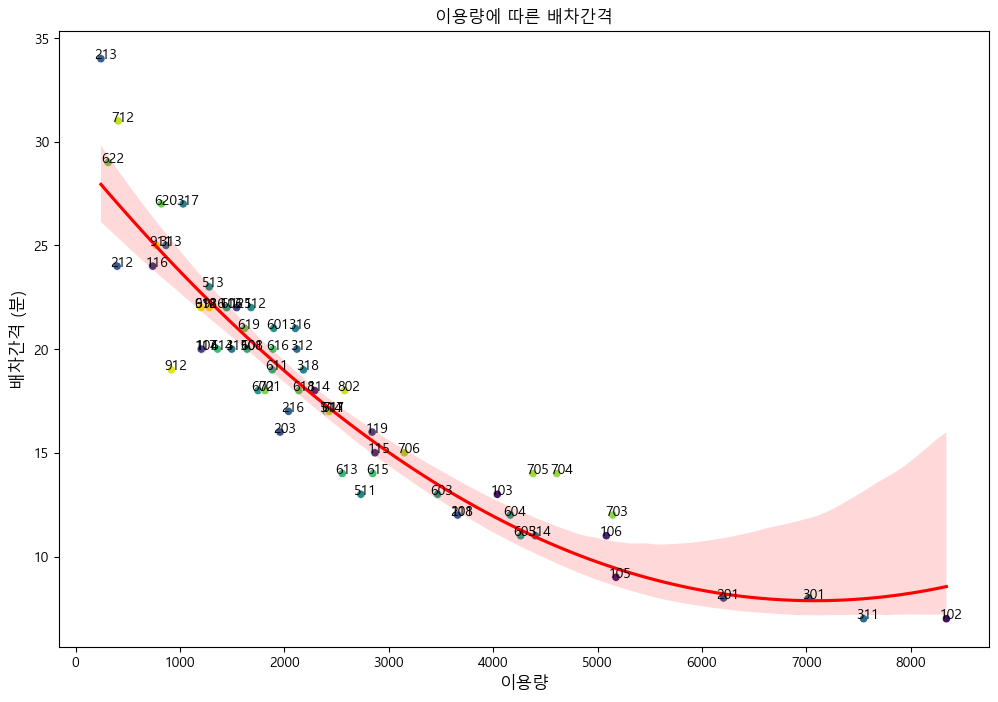

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 산점도 그래프 그리기
sns.scatterplot(data=bus_usage_merge_work, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")

# 2차 곡선 회귀선 그리기
sns.regplot(data=bus_usage_merge_work, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, order=2, color='black', line_kws={"color": "red"})

# 데이터 포인트에 레이블 달기
for route, usage, interval in zip(bus_usage_merge_work["ROUTE_NO"], bus_usage_merge_work["USAGE_COUNT"], bus_usage_merge_work["ALLO_INTERVAL"]):
    plt.annotate(route,
                 xy=(usage, interval),
                 xytext=(-5, 0),
                 textcoords='offset points',
                 fontsize=10)

# X, Y 축 레이블 및 타이틀 설정
plt.xlabel("이용량",fontsize = 12)
plt.ylabel("배차간격 (분)",fontsize = 12)
plt.title("이용량에 따른 배차간격",fontsize = 12)

# 회귀선 계수 계산
a, b, c = np.polyfit(bus_usage_merge_work["USAGE_COUNT"], bus_usage_merge_work["ALLO_INTERVAL"], 2)  # 2차 곡선이므로 2로 수정

# 회귀선과의 거리 계산 및 데이터프레임에 추가
distances = []
for x, y in zip(bus_usage_merge_work["USAGE_COUNT"], bus_usage_merge_work["ALLO_INTERVAL"]):
    y_pred = a * x**2 + b * x + c  # 2차 곡선 방정식
    distance = y - y_pred
    distances.append(distance)

# 거리를 데이터프레임에 추가
bus_usage_merge_work["Distance_WORK"] = distances

# 범례 제거
plt.legend().remove()

# 거리가 추가된 데이터프레임 출력
plt.show()
# output_line_work

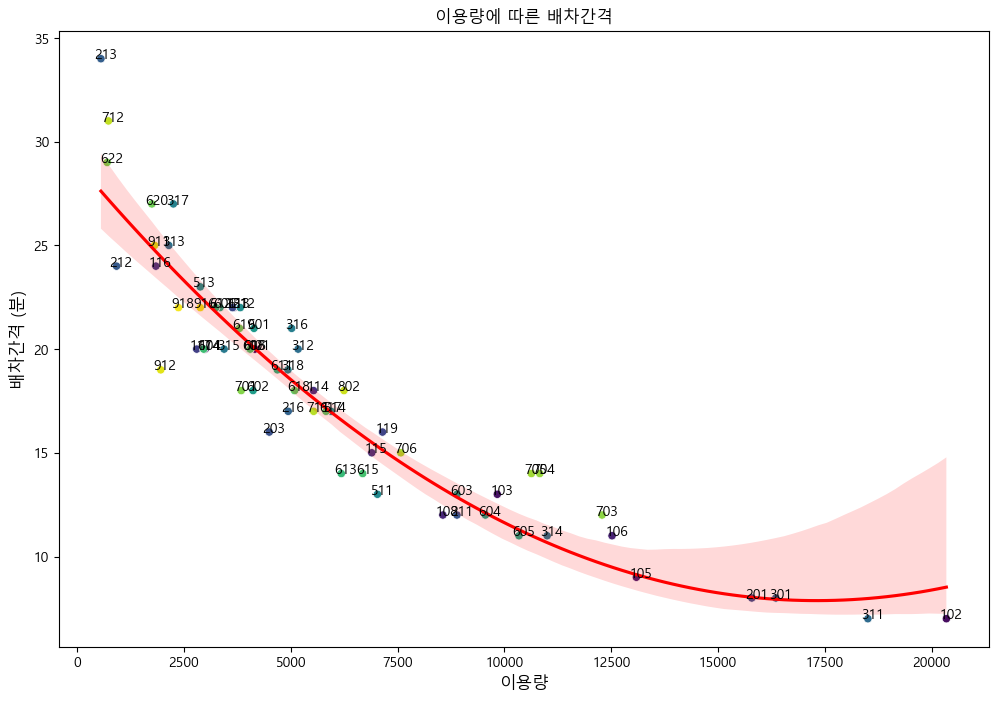

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 산점도 그래프 그리기
sns.scatterplot(data=bus_usage_merge_all, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")

# 2차 곡선 회귀선 그리기
sns.regplot(data=bus_usage_merge_all, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, order=2, color='black', line_kws={"color": "red"})

# 데이터 포인트에 레이블 달기
for route, usage, interval in zip(bus_usage_merge_all["ROUTE_NO"], bus_usage_merge_all["USAGE_COUNT"], bus_usage_merge_all["ALLO_INTERVAL"]):
    plt.annotate(route,
                 xy=(usage, interval),
                 xytext=(-5, 0),
                 textcoords='offset points',
                 fontsize=10)

# X, Y 축 레이블 및 타이틀 설정
plt.xlabel("이용량", fontsize = 12)
plt.ylabel("배차간격 (분)", fontsize = 12)
plt.title("이용량에 따른 배차간격", fontsize = 12)

# 회귀선의 방정식 계산
a, b, c = np.polyfit(bus_usage_merge_all["USAGE_COUNT"], bus_usage_merge_all["ALLO_INTERVAL"], 2)  # 2차 곡선이므로 2로 수정

# 회귀선과의 거리 계산 및 데이터프레임에 추가
distances = []
for x, y in zip(bus_usage_merge_all["USAGE_COUNT"], bus_usage_merge_all["ALLO_INTERVAL"]):
    y_pred = a * x**2 + b * x + c  # 2차 곡선 방정식
    distance = y - y_pred
    distances.append(distance)

# 거리를 데이터프레임에 추가
bus_usage_merge_all["Distance"] = distances

# 범례 제거
plt.legend().remove()

plt.show()

# 거리가 추가된 데이터프레임 출력
# print(bus_usage_merge_all.head())


In [53]:
bus_usage_merge_work

,ROUTE_NO,USAGE_COUNT,ALLO_INTERVAL,Distance_WORK
0,101,1647,20,-0.547685
1,102,8342,7,-1.550974
2,103,4040,13,1.158978
3,104,1213,20,-2.653361
4,105,5177,9,-0.426890
...,...,...,...,...
60,802,2578,18,1.423873
61,911,772,25,0.041375
62,912,918,19,-5.176944
63,916,1283,22,-0.302800


In [59]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo

# 2차 곡선 회귀선 계수 계산
a, b, c = np.polyfit(bus_usage_merge_all["USAGE_COUNT"], bus_usage_merge_all["ALLO_INTERVAL"], 2)

# 2차 곡선 회귀선 함수 정의
def quadratic_regression(x):
    return a * x**2 + b * x + c

# 산점도 그래프 생성
fig = px.scatter(bus_usage_merge_all, x="USAGE_COUNT", y="ALLO_INTERVAL", color="ROUTE_NO", 
                 labels={"USAGE_COUNT": "이용량", "ALLO_INTERVAL": "배차간격 (분)", "ROUTE_NO": "노선번호"})

# 회귀선 그리기
x_range = np.linspace(bus_usage_merge_all["USAGE_COUNT"].min(), bus_usage_merge_all["USAGE_COUNT"].max(), 100)
y_range = [quadratic_regression(x) for x in x_range]

fig.add_trace(go.Scatter(x=x_range, y=y_range, mode="lines", name="2차 곡선 회귀선", line=dict(color='red')))

# 그래프 레이아웃 설정
fig.update_layout(
    title="이용량에 따른 배차간격",
    xaxis_title="이용량",
    yaxis_title="배차간격 (분)",
    legend_title="노선번호",
    showlegend=True,
    legend=dict(x=9000, y=1.1),
    font=dict(family="Malgun Gothic"),
    hovermode="closest"
)

# x축 레이블을 원하는 형식으로 설정 (5000과 같이)
fig.update_xaxes(
    tickvals=[5000, 10000, 15000, 20000],  # x축의 눈금 위치
    ticktext=["5000", "10000", "15000", "20000"]  # 눈금에 표시될 텍스트
)

# 그래프 표시
fig.show()
pyo.plot(fig, filename='bus_usage_graph_all.html')


'bus_usage_graph_all.html'

In [58]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo

# 2차 곡선 회귀선 계수 계산
a, b, c = np.polyfit(bus_usage_merge_work["USAGE_COUNT"], bus_usage_merge_work["ALLO_INTERVAL"], 2)

# 2차 곡선 회귀선 함수 정의
def quadratic_regression(x):
    return a * x**2 + b * x + c

# 산점도 그래프 생성
fig = px.scatter(bus_usage_merge_work, x="USAGE_COUNT", y="ALLO_INTERVAL", color="ROUTE_NO", 
                 labels={"USAGE_COUNT": "이용량", "ALLO_INTERVAL": "배차간격 (분)", "ROUTE_NO": "노선번호"})

# 회귀선 그리기
x_range = np.linspace(bus_usage_merge_work["USAGE_COUNT"].min(), bus_usage_merge_work["USAGE_COUNT"].max(), 100)
y_range = [quadratic_regression(x) for x in x_range]

fig.add_trace(go.Scatter(x=x_range, y=y_range, mode="lines", name="2차 곡선 회귀선", line=dict(color='red')))

# 그래프 레이아웃 설정
fig.update_layout(
    title="이용량에 따른 배차간격",
    xaxis_title="이용량",
    yaxis_title="배차간격 (분)",
    legend_title="노선번호",
    showlegend=True,
    legend=dict(x=9000, y=1.1),
    font=dict(family="Malgun Gothic"),
    hovermode="closest"
)

# 그래프 표시
fig.show()
pyo.plot(fig, filename='bus_usage_graph_work.html')



'bus_usage_graph_work.html'

In [99]:
# 새로운 열 'coordinate'를 생성하여 좌표를 저장
bus_usage_merge_all['coordinate'] = list(zip(bus_usage_merge_all['USAGE_COUNT'], bus_usage_merge_all['ALLO_INTERVAL']))

# 'ROUTE_NO'를 기준으로 그룹화하여 각 노선별 좌표 리스트를 저장
coordinates_by_route = bus_usage_merge_all.groupby('ROUTE_NO')['coordinate'].apply(list).reset_index()

# 각 노선의 좌표 리스트를 출력
for index, row in coordinates_by_route.iterrows():
    route_no = row['ROUTE_NO']
    coordinates = row['coordinate']


In [100]:
close_to_the_regression_line = bus_usage_merge_all.sort_values('Distance').head(15)

In [105]:
bus_601_usage_count

4141

In [107]:
closest_routes[closest_routes['USAGE_COUNT']<=4141]

,ROUTE_NO,USAGE_COUNT,ALLO_INTERVAL,Distance,coordinate,Distance_601,Distance_704
36,602,4119,18,-2.114730,"(4119, 18)",22.203603,6709.001192
53,701,3842,18,-2.634403,"(3842, 18)",299.015050,6986.001145
27,315,3442,20,-1.403896,"(3442, 20)",699.000715,7386.002437


In [110]:
# 601번 버스의 USAGE_COUNT와 ALLO_INTERVAL 값 가져오기
bus_601_usage_count = bus_usage_merge_all[bus_usage_merge_all['ROUTE_NO'] == '601']['USAGE_COUNT'].values[0]
bus_601_allo_interval = bus_usage_merge_all[bus_usage_merge_all['ROUTE_NO'] == '601']['ALLO_INTERVAL'].values[0]

# 거리 계산 함수 정의
def calculate_distance(row):
    return np.sqrt((row['USAGE_COUNT'] - bus_601_usage_count)**2 + (row['ALLO_INTERVAL'] - bus_601_allo_interval)**2)

# 거리 계산 및 데이터프레임에 추가
bus_usage_merge_all['Distance_601'] = close_to_the_regression_line.apply(calculate_distance, axis=1)

# 601번 버스와 가장 가까운 노선 3개 찾기
closest_routes = bus_usage_merge_all[bus_usage_merge_all['ROUTE_NO'] != '601'].nsmallest(5, 'Distance_601')
closest_routes = closest_routes[closest_routes['USAGE_COUNT']<=bus_601_usage_count]

print("가장 가까운 노선 정보 (상위 3개):")
closest_routes

가장 가까운 노선 정보 (상위 3개):


,ROUTE_NO,USAGE_COUNT,ALLO_INTERVAL,Distance,coordinate,Distance_601,Distance_704
36,602,4119,18,-2.114730,"(4119, 18)",22.203603,6709.001192
53,701,3842,18,-2.634403,"(3842, 18)",299.015050,6986.001145
27,315,3442,20,-1.403896,"(3442, 20)",699.000715,7386.002437


In [112]:
# 704번 버스의 USAGE_COUNT와 ALLO_INTERVAL 값 가져오기
bus_704_usage_count = bus_usage_merge_all[bus_usage_merge_all['ROUTE_NO'] == '704']['USAGE_COUNT'].values[0]
bus_704_allo_interval = bus_usage_merge_all[bus_usage_merge_all['ROUTE_NO'] == '704']['ALLO_INTERVAL'].values[0]

# 거리 계산 함수 정의
def calculate_distance(row):
    return np.sqrt((row['USAGE_COUNT'] - bus_704_usage_count)**2 + (row['ALLO_INTERVAL'] - bus_704_allo_interval)**2)

# 거리 계산 및 데이터프레임에 추가
bus_usage_merge_all['Distance_704'] = close_to_the_regression_line.apply(calculate_distance, axis=1)

# 704번 버스와 가장 가까운 노선 3개 찾기
closest_routes = bus_usage_merge_all[bus_usage_merge_all['ROUTE_NO'] != '704'].nsmallest(3, 'Distance_704')
closest_routes = closest_routes[closest_routes['USAGE_COUNT']<=bus_704_usage_count]

print("가장 가까운 노선 정보 (상위 3개):")
closest_routes

가장 가까운 노선 정보 (상위 3개):


,ROUTE_NO,USAGE_COUNT,ALLO_INTERVAL,Distance,coordinate,Distance_601,Distance_704
31,511,7030,13,-2.306737,"(7030, 13)",2889.011076,3798.000132
46,615,6685,14,-1.814245,"(6685, 14)",2544.009630,4143.000000
44,613,6184,14,-2.581070,"(6184, 14)",2043.011992,4644.000000


In [75]:
# 601번 버스의 USAGE_COUNT와 ALLO_INTERVAL
bus_601_usage_count = 4141  # 예시 값, 실제로는 SMART_CARD_DATA에서 추출해야 합니다.
bus_601_allo_interval = 21  # 예시 값, 실제로는 SMART_CARD_DATA에서 추출해야 합니다.

# Distance 변수가 음수이면서, 601번 버스의 USAGE_COUNT 및 ALLO_INTERVAL보다 작은 노선 3개 선택
close_to_the_regression_line = close_to_the_regression_line[
    (close_to_the_regression_line['Distance'] < 0) &
    (close_to_the_regression_line['USAGE_COUNT'] < bus_601_usage_count) &
    (close_to_the_regression_line['ALLO_INTERVAL'] < bus_601_allo_interval)
].nlargest(5, 'Distance')

print(close_to_the_regression_line.sort_values('Distance'))


   ROUTE_NO  USAGE_COUNT  ALLO_INTERVAL  Distance  coordinate
53      701         3842             18 -2.634403  (3842, 18)
36      602         4119             18 -2.114730  (4119, 18)


In [13]:
# 601번 버스 좌표 추출
bus_601_coordinates = bus_usage_merge_all[bus_usage_merge_all['ROUTE_NO'] == '601']['coordinate'].values[0]

# 모든 노선과의 거리 계산
bus_usage_merge_all['Distance_Diff'] = bus_usage_merge_all['coordinate'].apply(lambda x: np.sqrt((x[0] - bus_601_coordinates[0])**2 + (x[1] - bus_601_coordinates[1])**2))

In [14]:
bus_usage_merge_all

,ROUTE_NO,USAGE_COUNT,ALLO_INTERVAL,Distance,coordinate,Distance_Diff
0,101,3803,20,-0.004908,"(3803, 20)",18.027756
1,102,18652,7,-1.523062,"(18652, 7)",14867.006592
2,103,8991,13,1.223724,"(8991, 13)",5206.006147
3,104,2722,20,-2.289651,"(2722, 20)",1063.000470
4,105,11963,9,-0.102873,"(11963, 9)",8178.008804
...,...,...,...,...,...,...
60,802,5697,18,1.524063,"(5697, 18)",1912.002354
61,911,1637,25,0.219421,"(1637, 25)",2148.003724
62,912,1772,19,-5.459857,"(1772, 19)",2013.000994
63,916,2614,22,-0.528718,"(2614, 22)",1171.000427


In [15]:
print(bus_usage_merge_all)

   ROUTE_NO  USAGE_COUNT  ALLO_INTERVAL  Distance  coordinate  Distance_Diff
0       101         3803             20 -0.004908  (3803, 20)      18.027756
1       102        18652              7 -1.523062  (18652, 7)   14867.006592
2       103         8991             13  1.223724  (8991, 13)    5206.006147
3       104         2722             20 -2.289651  (2722, 20)    1063.000470
4       105        11963              9 -0.102873  (11963, 9)    8178.008804
..      ...          ...            ...       ...         ...            ...
60      802         5697             18  1.524063  (5697, 18)    1912.002354
61      911         1637             25  0.219421  (1637, 25)    2148.003724
62      912         1772             19 -5.459857  (1772, 19)    2013.000994
63      916         2614             22 -0.528718  (2614, 22)    1171.000427
64      918         2142             22 -1.596563  (2142, 22)    1643.000304

[63 rows x 6 columns]


In [163]:
selected_routes = nearest_routes[(nearest_routes['Distance'] < 0) & (nearest_routes['USAGE_COUNT'] < 3785) & (nearest_routes['ALLO_INTERVAL'] < 21)]
selected_routes


,ROUTE_NO,USAGE_COUNT,ALLO_INTERVAL,Distance,coordinate,Distance_Diff
36,602,3733,18,-2.146902,"(3733, 18)",52.086467
41,608,3700,20,-0.214128,"(3700, 20)",85.005882
47,616,3674,20,-0.267223,"(3674, 20)",111.004504
53,701,3476,18,-2.675293,"(3476, 18)",309.014563


In [126]:
bus_usage_merge_work.columns = ['ROUTE_NO_WORK','USAGE_COUNT_WORK','ALLO_INTERVAL_WORK','Distance_WORK']

In [127]:
display(bus_usage_merge_work.head(2))
display(bus_usage_merge_all.head(2))

,ROUTE_NO_WORK,USAGE_COUNT_WORK,ALLO_INTERVAL_WORK,Distance_WORK
0,101,1499,20,-0.536556
1,102,7616,7,-1.536805


,ROUTE_NO,USAGE_COUNT,ALLO_INTERVAL,Distance
0,101,3803,20,-0.004908
1,102,18652,7,-1.523062


In [128]:
bus_linear_line = pd.concat([bus_usage_merge_all, bus_usage_merge_work], axis = 1)
bus_linear_line = bus_linear_line[['ROUTE_NO','ALLO_INTERVAL','Distance','Distance_WORK']]
bus_linear_line['DISTANCE'] = bus_linear_line['Distance'] - bus_linear_line['Distance_WORK']
bus_linear_line['DISTANCE'] = bus_linear_line['DISTANCE'].abs()
bus_linear_line

,ROUTE_NO,ALLO_INTERVAL,Distance,Distance_WORK,DISTANCE
0,101,20,-0.004908,-0.536556,0.531647
1,102,7,-1.523062,-1.536805,0.013742
2,103,13,1.223724,1.162152,0.061571
3,104,20,-2.289651,-2.686495,0.396844
4,105,9,-0.102873,-0.438700,0.335827
...,...,...,...,...,...
60,802,18,1.524063,1.458804,0.065259
61,911,25,0.219421,0.042909,0.176512
62,912,19,-5.459857,-5.188073,0.271784
63,916,22,-0.528718,-0.340163,0.188555


In [130]:
bus_linear_line[bus_linear_line['Distance'] < 0]

,ROUTE_NO,ALLO_INTERVAL,Distance,Distance_WORK,DISTANCE
0,101,20,-0.004908,-0.536556,0.531647
1,102,7,-1.523062,-1.536805,0.013742
3,104,20,-2.289651,-2.686495,0.396844
4,105,9,-0.102873,-0.438700,0.335827
6,108,12,-1.244549,-0.901187,0.343363
9,115,15,-0.524023,-0.503380,0.020644
10,116,24,-0.706660,-1.135691,0.429030
11,117,20,-2.684717,-2.703089,0.018372
16,201,8,-0.022434,-0.190329,0.167894
17,203,16,-3.449130,-3.178979,0.270151


In [84]:
bus_linear_line.loc[bus_linear_line['ROUTE_NO'] == '601', 'Distance'].values[0]

0.9586577409854016

---
확대그래프

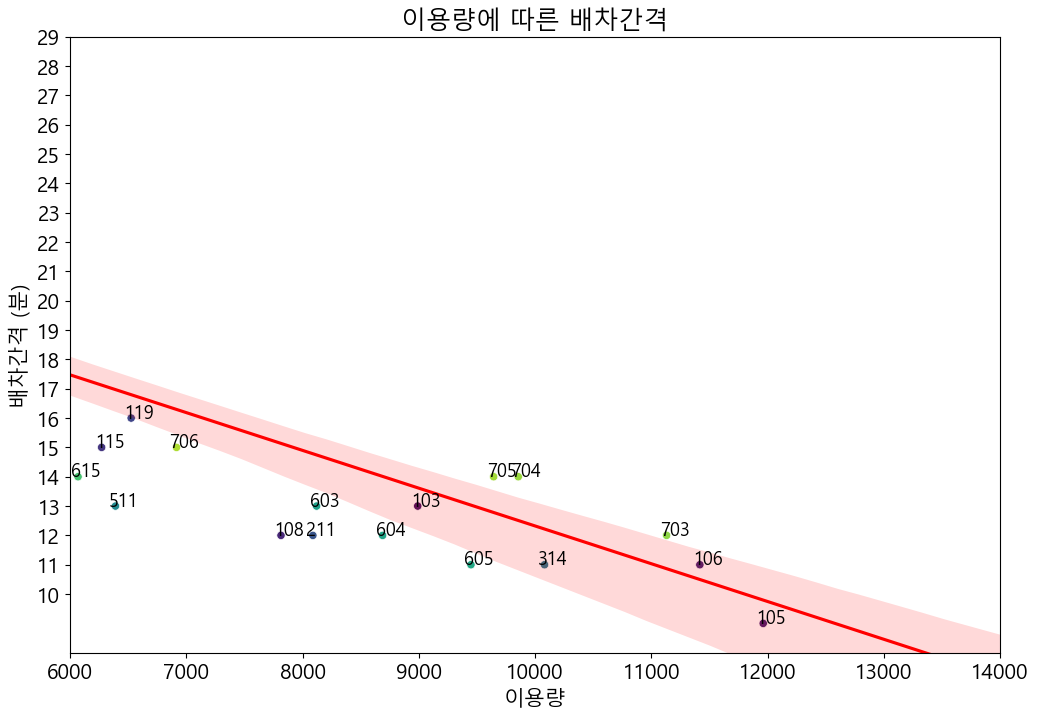

In [63]:
# 확대한 그래프
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 전체 데이터에 대한 산점도와 회귀선 그리기
sns.scatterplot(data=bus_usage_merge_all, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")
sns.regplot(data=bus_usage_merge_all, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, color='black', line_kws={"color": "red"})

# 데이터 포인트에 레이블 달기
for route, usage, interval in zip(bus_usage_merge_all["ROUTE_NO"], bus_usage_merge_all["USAGE_COUNT"], bus_usage_merge_all["ALLO_INTERVAL"]):
    plt.annotate(route,
                 xy=(usage, interval),
                 xytext=(-5, 0),
                 textcoords='offset points',
                 fontsize=13)

# X, Y 축 레이블 및 타이틀 설정
plt.xlabel("이용량")
plt.ylabel("배차간격 (분)")
plt.title("이용량에 따른 배차간격")

# 이용량이 6000에서 14000 사이인 데이터만 추출
filtered_data = bus_usage_merge_all[(bus_usage_merge_all["USAGE_COUNT"] >= 6000) & (bus_usage_merge_all["USAGE_COUNT"] <= 14000)]

# # 이용량이 6000에서 14000 사이인 데이터 중에서 노선 번호만 추출하여 범례 표시
# legend_labels = filtered_data["ROUTE_NO"].unique()
# plt.legend(labels=legend_labels)
plt.legend().set_visible(False)

# 이용량이 6000에서 14000 사이인 부분만 확대해서 보여주기
plt.xlim(6000, 14000)
plt.ylim(8, 20)  # 배차간격에 따라 범위 조절

# Y 축 눈금 설정 (1분 간격)
plt.yticks(np.arange(10, 30, 1))
plt.rc('font', size = 15)
plt.show()


In [38]:
# # 확대한 그래프
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 그래프 크기 설정
# plt.figure(figsize=(12, 8))

# # 전체 데이터에 대한 산점도와 회귀선 그리기
# sns.scatterplot(data=bus_usage_merge, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")
# sns.regplot(data=bus_usage_merge, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, color='black', line_kws={"color": "red"})

# # 데이터 포인트에 레이블 달기
# for route, usage, interval in zip(bus_usage_merge["ROUTE_NO"], bus_usage_merge["USAGE_COUNT"], bus_usage_merge["ALLO_INTERVAL"]):
#     plt.annotate(route,
#                  xy=(usage, interval),
#                  xytext=(-5, 0),
#                  textcoords='offset points',
#                  fontsize=13)

# # X, Y 축 레이블 및 타이틀 설정
# plt.xlabel("이용량")
# plt.ylabel("배차간격 (분)")
# plt.title("이용량에 따른 배차간격")

# # 이용량이 6000에서 14000 사이인 데이터만 추출
# filtered_data = bus_usage_merge[(bus_usage_merge["USAGE_COUNT"] >= 6000) & (bus_usage_merge["USAGE_COUNT"] <= 14000)]

# # # 이용량이 6000에서 14000 사이인 데이터 중에서 노선 번호만 추출하여 범례 표시
# # legend_labels = filtered_data["ROUTE_NO"].unique()
# # plt.legend(labels=legend_labels)
# plt.legend().set_visible(False)

# # 이용량이 6000에서 14000 사이인 부분만 확대해서 보여주기
# plt.xlim(6000, 14000)
# plt.ylim(8, 20)  # 배차간격에 따라 범위 조절

# # Y 축 눈금 설정 (1분 간격)
# plt.yticks(np.arange(8, 21, 1))
# plt.rc('font', size = 15)
# plt.show()


---